In [1]:
from configobj import ConfigObj
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

from astropy.coordinates import Angle

from astroplan import Observer
from astropy.io import fits

import dispersion_functions as diff_func
import math
import matplotlib as mpl
plt.style.use('bmh')

In [2]:
class AD_simulation:
    def __init__(self):
        self.input={}
        self.output={}
        
        self.config=ConfigObj('conf.ini')
        
    def load_wavelengths(self,start,end,sampling,diameter):
        """
        start, end, sampling: microns
        diameter: arcsec
        """
        self.output['wavelengths']=np.arange(start,end,sampling)
        self.output['diameter']=diameter
        
    def load_MOSAIC_band(self,regime,band,sampling,res="LR"):
        """
        regime: 1) "VIS", or 2) "NIR"
        band: 1) "B", "G", "R", or "All", or 2) "IY", "J", "H", or "All"
        sampling: microns
        res: "LR" or "HR"
        """
        wave_min= float(self.config["Bands"][res][regime][band]["wave_min"])
        wave_max= float(self.config["Bands"][res][regime][band]["wave_max"])

        self.output['wavelengths'] = np.arange(wave_min,wave_max,sampling)   
        self.output['diameter']=float(self.config["Aperture"][regime+"_major_axis"])
        
    def load_HA(self,HA_range,targ_dec):
        self.input['HA_range']=HA_range
        self.input['targ_dec']=targ_dec

        #latitude needs to be negative for now
        lat = float(self.config["Environment"]["latitude"]) * np.pi/180
        dec = targ_dec*np.pi/180
        
        #Need to check if the target is below the horizon for the given list of HA, and if so remove it.
        LHA_below_horizon=np.rad2deg(np.arccos(-np.tan(lat)*np.tan(dec)))/15 
        if str(LHA_below_horizon) != 'nan': 
            print("Target goes below Horizon above/below HA of +/- %2.1fh" % (LHA_below_horizon))
            for val in HA_range.copy(): 
                if abs(val) > abs(LHA_below_horizon):
                    print("At HA %2.2fh, target goes below horizon - removing this from HA range" % (val))
                    HA_range.remove(val)        
        if dec > np.pi/2 + lat: #If the target has a too high declination, it will never be seen at Cerro Paranal
            print("Target always below Horizon")
            return

        airmasses=1/(np.sin(lat)*np.sin(dec)+np.cos(lat)*np.cos(dec)*np.cos(Angle(HA_range*u.hour).rad))

        self.output['meridian_airmass'] = 1/(np.sin(lat)*np.sin(dec)+np.cos(lat)*np.cos(dec)*np.cos(Angle(0*u.hour).rad)) #Lowest airmass the target will be at

        para_angles=diff_func.parallatic_angle(np.array(HA_range),dec,lat)
        
        self.output['raw_para_angles']=np.array(para_angles) #actual PAs
        self.output['airmasses']=np.array(airmasses)
    
    def calculate_shifts(self, guide_waveref, aperture_waveref, centring="mid HA"):
        self.input['guide_waveref']=guide_waveref
        self.input['aperture_waveref']=aperture_waveref

        airmasses=self.output['airmasses']
        wavelengths=self.output['wavelengths']

        #centring refers to the index of the hour angles at which we centre the aperture/guiding on a wavelength
        if centring == "mid HA":
            centring_index=int((len(airmasses)-1)/2)
        if type(centring) == int:
            centring_index=centring

        self.input['centred_on']=str(self.input['HA_range'][centring_index])+"h"
        centre_shift=diff_func.diff_shift(aperture_waveref,airmasses[centring_index],guide_waveref) #shift of the original aperture centre wavelength from guide wavelength
        self.output['centre_shift']=centre_shift

        raw_para_angles=self.output['raw_para_angles']
        para_angles=self.output['raw_para_angles'].copy()
        for i in range(0,len(para_angles)): #change in PAs from centring index
            para_angles[i]=para_angles[i]-self.output['raw_para_angles'][centring_index]
        self.input['centred_q']=self.output['raw_para_angles'][centring_index]
        self.output['delta_para_angles']=para_angles
        
        shifts_no_para=[]
        shifts_para=[]
        shifts_para_v2=[]
        for count,airmass in enumerate(airmasses): #for each airmass, calculate AD shift
            shift_vals=diff_func.diff_shift(wavelengths,airmass,guide_waveref)
            shifts_no_para.append(shift_vals-centre_shift)
            
            airmass_shifts=[]
            airmass_shifts_v2=[]
            for i in range(0,len(shift_vals)):
                x=(shift_vals[i])*np.sin(para_angles[count])
                y=(shift_vals[i])*np.cos(para_angles[count])-centre_shift
                
                x_v2=(shift_vals[i])*np.sin(raw_para_angles[count])-centre_shift*np.sin(self.input['centred_q'])
                y_v2=(shift_vals[i])*np.cos(raw_para_angles[count])-centre_shift*np.cos(self.input['centred_q'])

                airmass_shifts.append([x,y])
                airmass_shifts_v2.append([x_v2,y_v2])
                
            shifts_para.append(airmass_shifts)
            shifts_para_v2.append(airmass_shifts_v2)
            
            #alternate way of calculating shifts
            #para_shift_v2=np.sqrt(shift_vals**2+centre_shift**2-2*shift_vals*centre_shift*np.cos(para_angles[count])) #Uses cosine rule to evaluate the shift from the aperture centre
            
        self.output['shifts_no_para']=np.array(shifts_no_para)
        #V1 is shifts  where y-axis is dispersion direction at centring
        self.output['shifts']=np.array(shifts_para)
        #V2 is shifts where y-axis is PA=0 
        self.output['shifts_v2']=np.array(shifts_para_v2)
    
    def load_PSFs(self):
        all_PSFs=[]
        all_aligned_PSFs=[]
        all_PSFs_totals=[]
        
        zero_shifts=np.zeros(np.shape(self.output['shifts'][0]))

        for i in range(0,len(self.output['airmasses'])):
            PSFs,PSFs_totals=diff_func.make_moffat_PSFs(self.output['wavelengths'],self.output['shifts'][i],self.output['airmasses'][i],self.output['diameter'])
            aligned_PSFs,blank=diff_func.make_moffat_PSFs(self.output['wavelengths'],zero_shifts,self.output['airmasses'][i],self.output['diameter'])
            
            all_PSFs.append(PSFs)
            all_aligned_PSFs.append(aligned_PSFs)
            all_PSFs_totals.append(PSFs_totals)
            
        self.output['PSFs']=all_PSFs
        self.output['aligned_PSFs']=all_aligned_PSFs
        self.output['PSFs_totals']=all_PSFs_totals
        
    def load_aperture(self,aperture_type="circle"):
        aperture=diff_func.make_aperture(aperture_type,self.output['diameter'])
        self.output['aperture']=aperture
           
    def calculate_transmissions(self):
        convolved_arrays=self.output['PSFs']*self.output['aperture']
        convolved_aligned_arrays=self.output['aligned_PSFs']*self.output['aperture']
        self.output['PSFs_through_aperture']=convolved_arrays
        self.output['aligned_PSFs_through_aperture']=convolved_aligned_arrays

        raw_transmissions=np.sum(convolved_arrays,axis=(-1,-2))/self.output['PSFs_totals']
        no_AD_transmissions=np.sum(convolved_aligned_arrays,axis=(-1,-2))/self.output['PSFs_totals']
        relative_transmissions=raw_transmissions/no_AD_transmissions

        self.output['raw_transmissions']=raw_transmissions
        self.output['no_AD_transmissions']=no_AD_transmissions
        self.output['relative_transmissions']=relative_transmissions

        relative_integration_transmissions=np.mean(relative_transmissions,axis=0)
        raw_integration_transmissions=np.mean(raw_transmissions,axis=0)
        self.output['raw_integration_transmission']=raw_integration_transmissions
        self.output['relative_integration_transmission']=relative_integration_transmissions
    

In [9]:
analysis=AD_simulation()
analysis.load_HA(np.linspace(3,4,3),-10.3)
analysis.load_MOSAIC_band("VIS","B",.001)
analysis.calculate_shifts(0.46,0.4,centring="mid HA")

analysis.load_aperture(aperture_type="hexagons")
analysis.load_PSFs()
analysis.calculate_transmissions()



Target goes below Horizon above/below HA of +/- 6.3h


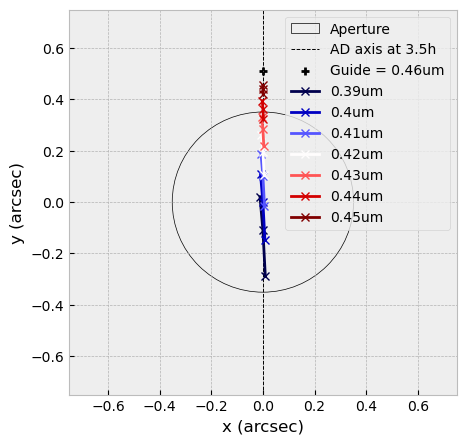

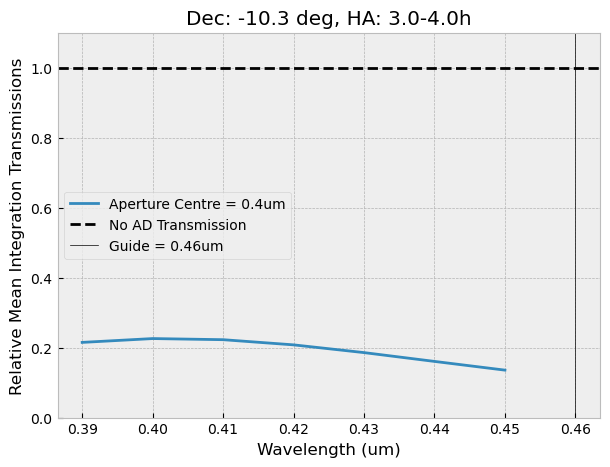

In [8]:
fig, ax = plt.subplots(figsize=[5,5]) 
weights = np.arange(0, len(analysis.output['wavelengths']))
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='seismic')
circle1 = plt.Circle((0, 0), analysis.output['diameter']/2, color='black', fill=False, label='Aperture')
ax.add_patch(circle1)    
plt.axvline(0,color='black',linestyle='--',linewidth=0.7,label="AD axis at {}".format(analysis.input['centred_on']))
plt.scatter(0,-analysis.output['centre_shift'],label='Guide = {}um'.format(analysis.input['guide_waveref']),color='black',marker='+')
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
shifts=analysis.output['shifts']
for i in range(0,len(shifts[0])):
    xs=[]
    ys=[]
    for o in range(0,len(shifts)):
        xs.append(shifts[o][i][0])
        ys.append(shifts[o][i][1]) 
    plt.plot(xs,ys,marker='x',color=cmap.to_rgba(i),label="{}um".format(round(analysis.output['wavelengths'][i],4)))
plt.legend()
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

plt.figure(figsize=[7,5])
plt.ylim(0,1.1)  
plt.plot(analysis.output['wavelengths'],analysis.output['raw_integration_transmission'],label="Aperture Centre = {}um".format(analysis.input['aperture_waveref']))
plt.xlabel("Wavelength (um)")
plt.ylabel("Relative Mean Integration Transmissions")
plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
plt.axvline(x=analysis.input['guide_waveref'],label="Guide = {}um".format(analysis.input['guide_waveref']),color='black',linewidth=0.5)
plt.title("Dec: {} deg, HA: {}-{}h".format(analysis.input['targ_dec'],analysis.input['HA_range'][0],analysis.input['HA_range'][-1]))
plt.legend()

In [5]:
print(np.shape(analysis.output['PSFs'][0]))

(7, 73, 73)


0.15680023464656154
0.19465158916033667


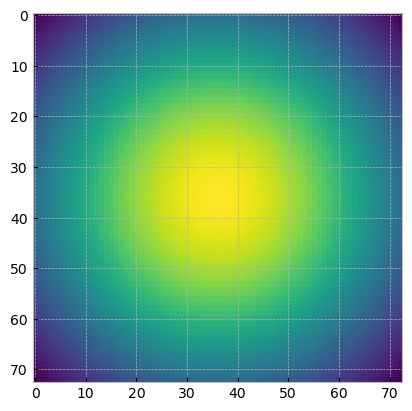

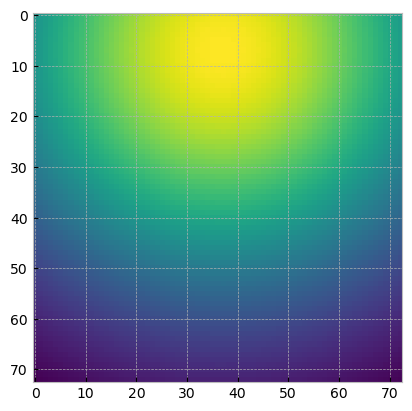

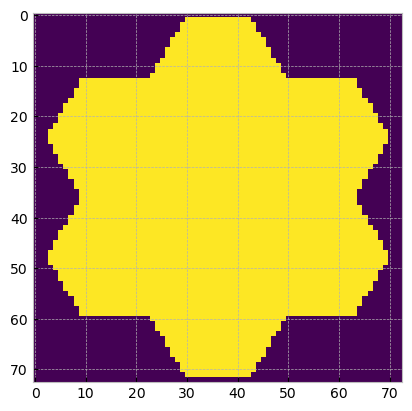

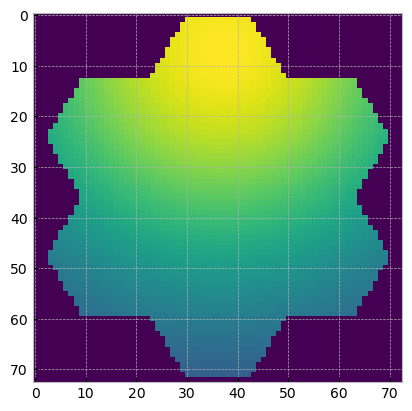

In [6]:
plt.figure()
plt.imshow(analysis.output['aligned_PSFs'][-1][0])
plt.figure()
plt.imshow(analysis.output['PSFs'][-1][0])
plt.figure()
plt.imshow(analysis.output['aperture'])
plt.figure()
plt.imshow(analysis.output['PSFs_through_aperture'][-1][0])

print(analysis.output['raw_transmissions'][-1][0])
print(analysis.output['no_AD_transmissions'][-1][0])